In [344]:
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
from sklearn.semi_supervised import LabelPropagation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import auc, roc_curve, make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

In [345]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [346]:
import warnings
warnings.filterwarnings("ignore")

In [347]:
from glob import glob
glob('./*')

['./main.ipynb',
 './Loan_Dataset.csv',
 './project_slides.pdf',
 './smote.ipynb',
 './README.md',
 './unsupervised4.ipynb',
 './unsupervised2.ipynb',
 './Loan_Dataset_final.csv',
 './Loan_Dataset_cleaned.csv',
 './unsupervised1.ipynb',
 './unsupervised3.ipynb']

In [348]:
df_ori = pd.read_csv('Loan_Dataset_final.csv')
df_ori.head()

,id,emp_length_num,Debt-To-Income Ratio,revol_util,od_ratio,bad_loan,annual_income_log,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,total_rec_late_fee_cat_non-zero,total_rec_late_fee_cat_zero
0,11454641,1,26.27,43.2,0.160624,0,11.512935,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True
1,9604874,4,5.39,21.5,0.810777,0,11.326608,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True
2,9684700,11,18.45,46.3,0.035147,1,11.264477,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True
3,9695736,6,12.28,10.7,0.534887,1,10.533082,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True
4,9795013,11,11.26,15.2,0.166500,0,11.082158,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True


In [349]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    #print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc, accuracy

def get_confusion_matrix(target_test, target_pred):
    matrix = confusion_matrix(target_test, target_pred)
    df = pd.DataFrame(matrix, index=['Actual Negative', 'Actual Positive'], 
                 columns=['Predicted Negative', 'Predicted Positive'])
    return df

<br> separate the dataset into two by original labels

In [351]:
df_0 = df_ori[df_ori.bad_loan == 0]
df_1 = df_ori[df_ori.bad_loan == 1]

use Gaussian Mixture to find clusters. setting n_components=2 because of the assumption that some of the observations in the good loans are 
mislabeled and should have been labeled as bad loans. and the same for the bad loans

In [353]:
gm = GaussianMixture(n_components=2, n_init=10, random_state=123)
gm.fit(df_0)

GaussianMixture(n_components=2, n_init=10, random_state=123)

In [354]:
gm.weights_

array([0.07557704, 0.92442296])

In [355]:
gm.converged_, gm.n_iter_

(True, 6)

In [356]:
gm_labels_for_0 = gm.predict(df_0)

In [357]:
gm_labels_for_0.mean()

0.924422959079458

In [358]:
df_0['gm_label'] = gm_labels_for_0
df_0.head()

,id,emp_length_num,Debt-To-Income Ratio,revol_util,od_ratio,bad_loan,annual_income_log,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,total_rec_late_fee_cat_non-zero,total_rec_late_fee_cat_zero,gm_label
0,11454641,1,26.27,43.2,0.160624,0,11.512935,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,1
1,9604874,4,5.39,21.5,0.810777,0,11.326608,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,1
4,9795013,11,11.26,15.2,0.166500,0,11.082158,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,1
7,7450630,1,6.41,55.9,0.238576,0,11.472114,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,1
8,9767996,11,26.27,94.1,0.674835,0,11.002117,False,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,1


In [359]:
gm2 = GaussianMixture(n_components=2, n_init=10, random_state=123)
gm2.fit(df_1)

GaussianMixture(n_components=2, n_init=10, random_state=123)

In [360]:
gm2.weights_

array([0.23773852, 0.76226148])

In [361]:
gm2.converged_, gm2.n_iter_

(True, 8)

In [362]:
gm_labels_for_1 = gm.predict(df_1)

In [363]:
gm_labels_for_1.mean()

0.8322020092316047

In [364]:
df_1['gm_label'] = gm_labels_for_1
df_1.head()

,id,emp_length_num,Debt-To-Income Ratio,revol_util,od_ratio,bad_loan,annual_income_log,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_36 months,term_60 months,last_delinq_none_0,last_delinq_none_1,total_rec_late_fee_cat_non-zero,total_rec_late_fee_cat_zero,gm_label
2,9684700,11,18.45,46.3,0.035147,1,11.264477,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,True,False,True,1
3,9695736,6,12.28,10.7,0.534887,1,10.533082,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,1
5,9856168,0,1.50,14.6,0.308410,1,10.727685,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,True,1
6,9825536,5,18.69,29.5,0.045062,1,10.714440,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,True,1
12,9808485,1,26.21,28.4,0.524121,1,10.616462,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,1


<br>
now we have a total of 4 clusters - let's name them a, b, c, d: <br>
cluster a: orginal label = 0 and gm label = 0<br>
cluster b: orginal label = 0 and gm label = 1<br>
cluster c: orginal label = 1 and gm label = 0<br>
cluster d: orginal label = 1 and gm label = 1<br>
<br>
but we still do not know the data points' true labels. and since we do not have the ground truth, we can only rely on using classifiers to find the label assginemnt that can convey the correct signal from data to a classifier. the algorithm is as followed: <br>
- there are a total of 12 (4*3) combinations<br>
- for each cluster, assign all data points the label 0<br>
- for each of the other clusters, assign the data points the label 1<br>
- for each combination of 0-labled and 1-labeled datasets, train and test a logistic regression classifier<br>
- for all the combinations, collect and compare the performances of the classifiers<br>

In [366]:
df_0.reset_index(drop=True, inplace=True)
df_1.reset_index(drop=True, inplace=True)

clusters = {
    'cluster_a' : df_0[df_0.gm_label == 0],
    'cluster_b' : df_0[df_0.gm_label == 1],
    'cluster_c' : df_1[df_0.gm_label == 0],
    'cluster_d' : df_1[df_0.gm_label == 1]
}

In [367]:
def train_test_pipeline(dataframe):
    X = dataframe.drop(columns=['id', 
                                 'new_label',
                                 'grade_A',
                                 'home_ownership_MORTGAGE',
                                 'purpose_car',
                                 'term_36 months',
                                 'last_delinq_none_0', 
                                 'total_rec_late_fee_cat_zero'])
    y = dataframe['new_label']

    #separate dataset into train and test sets
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
    train_ind, test_ind = next(sss.split(X, y, groups=None))
    X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]
    
    #standardize data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #train a logistric regression classifier
    lg_clf = LogisticRegression(class_weight='balanced', random_state = 123)
    lg_clf.fit(X_train, y_train)
    y_pred = lg_clf.predict(X_test)
    y_score = lg_clf.predict_proba(X_test)[:, 1]
    lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc, lg_accuracy = get_metrics(y_test, y_score, y_pred)
    
    return lg_pr_auc, lg_roc_auc, lg_accuracy

In [368]:
cluster_list = []
pr_auc = []
roc_auc = []
accuracies = []
dataset_sizes = []
count_of_1s = []

for cluster_1 in clusters.keys():
    df_1 = clusters[cluster_1]
    df_1 = df_1.drop(columns = ['bad_loan', 'gm_label'])
    df_1['new_label'] = np.zeros(shape = df_1.shape[0], dtype = np.int8)
    for cluster_2 in clusters.keys(): 
        if cluster_2 != cluster_1:
            df_2 = clusters[cluster_2]
            df_2 = df_2.drop(columns = ['bad_loan', 'gm_label'])
            df_2['new_label'] = np.ones(shape = df_2.shape[0], dtype = np.int8)
            df = pd.concat([df_1, df_2])
            df = df.reset_index(drop=True)
            lg_pr_auc, lg_roc_auc, lg_accuracy = train_test_pipeline(df)
            
            cluster_list.append(cluster_1+" & "+cluster_2)
            pr_auc.append(lg_pr_auc)
            roc_auc.append(lg_roc_auc)
            accuracies.append(lg_accuracy)
            dataset_sizes.append(df.shape[0])
            count_of_1s.append(df.new_label.sum())

In [369]:
table = pd.DataFrame(
    {'clusters': cluster_list,
     'dataset size': dataset_sizes,
     'count of 1': count_of_1s,
     'precision recall auc': pr_auc,
     'receiver operating characteristic auc': roc_auc,
     'accuracy': accuracies})

table.sort_values('precision recall auc', ascending=False)

,clusters,dataset size,count of 1,precision recall auc,receiver operating characteristic auc,accuracy
3,cluster_b & cluster_a,14687,1110,1.000000,1.000000,0.999660
0,cluster_a & cluster_b,14687,13577,0.999947,0.999302,0.998979
7,cluster_c & cluster_b,13841,13577,0.991203,0.734154,0.697003
6,cluster_c & cluster_a,1374,1110,0.990578,0.967874,0.960000
2,cluster_a & cluster_d,4529,3419,0.984883,0.946940,0.888521
1,cluster_a & cluster_c,1374,264,0.954201,0.977138,0.960000
8,cluster_c & cluster_d,3683,3419,0.935489,0.533377,0.484396
10,cluster_d & cluster_b,16996,13577,0.910140,0.744117,0.701471
9,cluster_d & cluster_a,4529,1110,0.728802,0.938965,0.881898
5,cluster_b & cluster_d,16996,3419,0.533278,0.761727,0.692941


In [370]:
table['percentage of 1'] = (table['count of 1']/table['dataset size']*100).round(2)

In [371]:
table = table.sort_values(by=['precision recall auc', 'percentage of 1'], ascending=[False, True])
table

,clusters,dataset size,count of 1,precision recall auc,receiver operating characteristic auc,accuracy,percentage of 1
3,cluster_b & cluster_a,14687,1110,1.000000,1.000000,0.999660,7.56
0,cluster_a & cluster_b,14687,13577,0.999947,0.999302,0.998979,92.44
7,cluster_c & cluster_b,13841,13577,0.991203,0.734154,0.697003,98.09
6,cluster_c & cluster_a,1374,1110,0.990578,0.967874,0.960000,80.79
2,cluster_a & cluster_d,4529,3419,0.984883,0.946940,0.888521,75.49
1,cluster_a & cluster_c,1374,264,0.954201,0.977138,0.960000,19.21
8,cluster_c & cluster_d,3683,3419,0.935489,0.533377,0.484396,92.83
10,cluster_d & cluster_b,16996,13577,0.910140,0.744117,0.701471,79.88
9,cluster_d & cluster_a,4529,1110,0.728802,0.938965,0.881898,24.51
5,cluster_b & cluster_d,16996,3419,0.533278,0.761727,0.692941,20.12


looks like cluster_b & cluster_a and cluster_c & cluster_d may have the right labels. going with these assignments causes less disturbance to the original labels. let's see if the classifiers will perform better with the new labels.

In [373]:
df_b = clusters['cluster_b'].drop(columns = ['bad_loan', 'gm_label'])
df_b['new_label'] = np.zeros(df_b.shape[0], dtype = np.int8)

df_a = clusters['cluster_a'].drop(columns = ['bad_loan', 'gm_label'])
df_a['new_label'] = np.ones(df_a.shape[0], dtype = np.int8)

df_c = clusters['cluster_c'].drop(columns = ['bad_loan', 'gm_label'])
df_c['new_label'] = np.zeros(df_c.shape[0], dtype = np.int8)

df_d = clusters['cluster_d'].drop(columns = ['bad_loan', 'gm_label'])
df_d['new_label'] = np.ones(df_d.shape[0], dtype = np.int8)

df_new = pd.concat([df_a, df_b, df_c, df_d])
df = df.reset_index(drop=True)

In [374]:
df_new.shape

(18370, 35)

In [375]:
df_new.describe()

,id,emp_length_num,Debt-To-Income Ratio,revol_util,od_ratio,annual_income_log,new_label
count,1.837000e+04,18370.000000,18370.000000,18370.000000,18370.000000,18370.000000,18370.000000
mean,7.594492e+06,6.827599,16.591305,55.732122,0.504960,11.077348,0.246543
std,1.609890e+06,3.769424,7.582904,23.421033,0.287797,0.487687,0.431010
min,5.860400e+05,0.000000,0.000000,0.000000,0.000077,9.037533,0.000000
25%,6.206278e+06,3.000000,10.850000,38.725000,0.257531,10.757924,0.000000
50%,7.379873e+06,7.000000,16.220000,57.100000,0.508002,11.082158,0.000000
75%,8.776018e+06,11.000000,22.060000,74.000000,0.753877,11.385103,0.000000
max,1.145464e+07,11.000000,34.990000,128.100000,0.999894,13.815512,1.000000


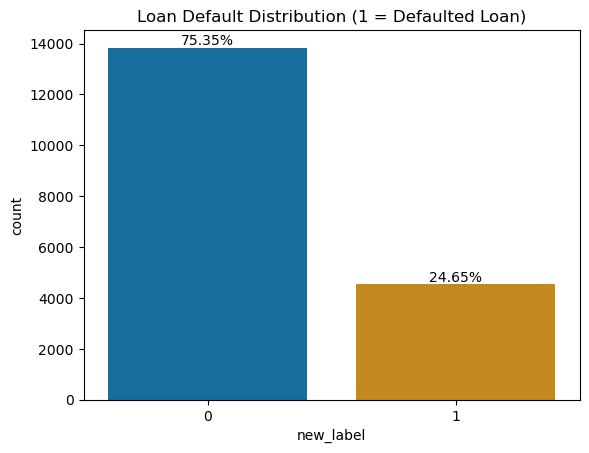

In [376]:
total_count = df_new.new_label.size

ax = sns.countplot(x='new_label', data=df_new, palette='colorblind')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan)')
plt.show()

In [377]:
def get_metrics(target_test, target_score, target_pred):
    precision, recall, thresholds = precision_recall_curve(target_test, target_score)
    fpr, tpr, thresholds = roc_curve(target_test, target_score)
    pr_auc = average_precision_score(target_test, target_score)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(target_test, target_pred)
    
    print(f'PR AUC is {pr_auc:.2f}. ROC AUC is {roc_auc:.2f}, Accuracy is {accuracy:.2f}')
    return precision, recall, pr_auc, fpr, tpr, roc_auc

In [378]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18370 entries, 40 to 3682
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               18370 non-null  int64  
 1   emp_length_num                   18370 non-null  int64  
 2   Debt-To-Income Ratio             18370 non-null  float64
 3   revol_util                       18370 non-null  float64
 4   od_ratio                         18370 non-null  float64
 5   annual_income_log                18370 non-null  float64
 6   grade_A                          18370 non-null  bool   
 7   grade_B                          18370 non-null  bool   
 8   grade_C                          18370 non-null  bool   
 9   grade_D                          18370 non-null  bool   
 10  grade_E                          18370 non-null  bool   
 11  grade_F                          18370 non-null  bool   
 12  grade_G                

In [379]:
X = df_new.drop(columns=['id', 
                     'new_label',
                     'grade_A',
                     'home_ownership_MORTGAGE',
                     'purpose_car',
                     'term_36 months',
                     'last_delinq_none_0', 
                     'total_rec_late_fee_cat_zero'])

y = df_new['new_label']

In [380]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=123)
train_ind, test_ind = next(sss.split(X,y,groups=None))
X_train, y_train, X_test, y_test = X.iloc[train_ind], y.iloc[train_ind], X.iloc[test_ind], y.iloc[test_ind]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<br> 
same as before in the smote notebook: for the training data, will over sample the minority class to have 50% of the majoirity class, then use random undersamping to reduce the number of samples in the majority class to have 50% more than the minority class. test data's target distribution will stay the same.

In [382]:
over = SMOTE(sampling_strategy=0.5)
X_over, y_over = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(sampling_strategy=0.5)
X_train_resampled, y_train_resampled = under.fit_resample(X_over, y_over)

In [383]:
X_train_resampled.shape

(16608, 27)

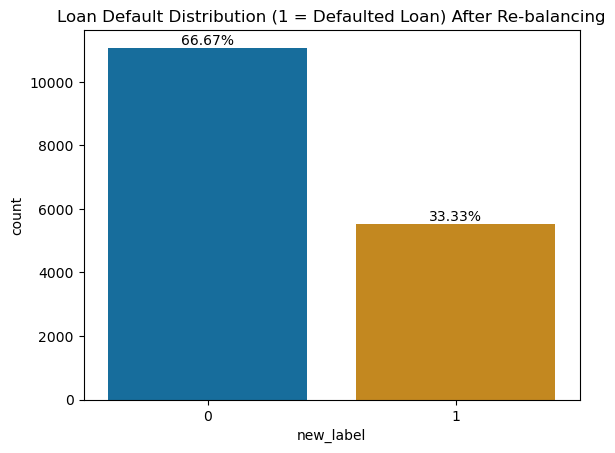

In [384]:
total_count = y_train_resampled.size

ax = sns.countplot(x=y_train_resampled, palette='colorblind')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 100, f'{height/total_count*100:.2f}%', ha='center')

plt.title('Loan Default Distribution (1 = Defaulted Loan) After Re-balancing')
plt.show()

### Logistic Regression

In [422]:
param_grid = [{'C': [1, 10, 100, 1000]}]

lg_clf = LogisticRegression(#class_weight='balanced',
                            random_state = 123
                           )
     
grid_search = GridSearchCV(lg_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                           #AP summarizes a precision-recall curve as the weighted mean of precisions achieved at 
                           #each threshold, with the increase in recall from the previous threshold used as the weight
                           #https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
                          return_train_score = True)
               
grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'C': 1}

In [424]:
lg_clf = grid_search.best_estimator_
lg_clf.fit(X_train_resampled, y_train_resampled)
y_pred = lg_clf.predict(X_test)
y_score = lg_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2685,83
Actual Positive,504,402


In [426]:
lg_precision, lg_recall, lg_pr_auc, lg_fpr, lg_tpr, lg_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.70. ROC AUC is 0.81, Accuracy is 0.84


### XGBoost

In [238]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = {0: class_weights[0], 1: class_weights[1]}

In [428]:
param_grid = [
    {'n_estimators': [94, 95, 96],
     'max_depth': [1,2, 3, 4],
     'learning_rate': [0.01, 0.1, 1]}]

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic',
                                    eval_metric='aucpr',
                                    #scale_pos_weight=class_weights[0]/class_weights[1],
                                    random_state = 123)

grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 95}

In [429]:
xgb_classifier = grid_search.best_estimator_
xgb_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = xgb_classifier.predict(X_test)
y_score = xgb_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2676,92
Actual Positive,517,389


In [430]:
xgb_precision, xgb_recall, xgb_pr_auc, xgb_fpr, xgb_tpr, xgb_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.68. ROC AUC is 0.79, Accuracy is 0.83


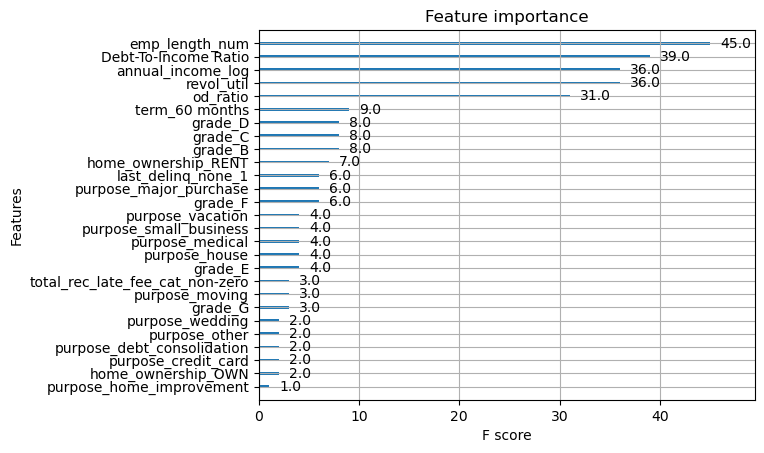

In [434]:
xgb_classifier.get_booster().feature_names =  list(X.columns)
xgb.plot_importance(xgb_classifier);

### Random Forest

In [436]:
param_grid = [
    {'n_estimators': [440, 450, 460],
     'max_depth': [5, 10, 15]}
]

rf_classifier = RandomForestClassifier(#class_weight=class_weights,
                                       random_state = 123)

grid_search = GridSearchCV(rf_classifier, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'max_depth': 15, 'n_estimators': 440}

In [437]:
best_params = grid_search.best_estimator_
rf_classifier.fit(X_train_resampled, y_train_resampled)
y_pred = rf_classifier.predict(X_test)
y_score = rf_classifier.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2673,95
Actual Positive,521,385


In [438]:
rf_precision, rf_recall, rf_pr_auc, rf_fpr, rf_tpr, rf_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.66. ROC AUC is 0.78, Accuracy is 0.83


In [439]:
feature_names = list(X.columns)
feature_importances = list()

for name, score in zip(feature_names, rf_classifier.feature_importances_):
    p = (name, score)
    feature_importances.append(p)

feature_importances = sorted(feature_importances, key=lambda x:x[1],reverse=True)
feature_importances

[('Debt-To-Income Ratio', 0.1345506004558727),
 ('revol_util', 0.12868991300486723),
 ('annual_income_log', 0.1279054353246113),
 ('od_ratio', 0.12596960277649757),
 ('grade_F', 0.08343448011874303),
 ('emp_length_num', 0.0808842224379275),
 ('purpose_major_purchase', 0.05203889123329988),
 ('term_60 months', 0.03276266620150361),
 ('total_rec_late_fee_cat_non-zero', 0.02606254867606545),
 ('last_delinq_none_1', 0.021371292860913767),
 ('home_ownership_RENT', 0.020166938886103478),
 ('grade_B', 0.017168894791069873),
 ('purpose_vacation', 0.014807296320370209),
 ('purpose_moving', 0.013393436302477529),
 ('grade_D', 0.013168521627558008),
 ('purpose_debt_consolidation', 0.0130105601758446),
 ('purpose_house', 0.012276581255606355),
 ('grade_G', 0.012229957726848253),
 ('grade_C', 0.012066721802974571),
 ('purpose_credit_card', 0.01074227267781827),
 ('grade_E', 0.009746106989703233),
 ('purpose_wedding', 0.009302625361669835),
 ('home_ownership_OWN', 0.007998146271120244),
 ('purpose_s

#### Gradient Descent Optimization

In [440]:
param_grid = [
    {'max_iter': list(range(50, 951, 100))}
]

sgd_clf = SGDClassifier(loss='log', 
                        learning_rate='optimal',
                        tol=1e-3,
                        #class_weight=class_weights,
                        random_state = 123)

grid_search = GridSearchCV(sgd_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'max_iter': 50}

In [441]:
sgd_clf = grid_search.best_estimator_
sgd_clf.fit(X_train_resampled, y_train_resampled)
y_pred = sgd_clf.predict(X_test)
y_score = sgd_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2662,106
Actual Positive,496,410


In [442]:
sgd_precision, sgd_recall, sgd_pr_auc, sgd_fpr, sgd_tpr, sgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.69. ROC AUC is 0.80, Accuracy is 0.84


### Mini-batch Gradient Descent

In [444]:
from sklearn.base import clone

batch_size = 150
sample_size = len(X_train_resampled)

#set aside a validation batch for mini-batch SGD
sss_2 = StratifiedShuffleSplit(n_splits=1, test_size=batch_size, train_size=sample_size-batch_size)
train_ind, val_ind = next(sss_2.split(X_train_resampled, y_train_resampled))
X_train_2, y_train_2, X_mini_val, y_mini_val = X_train_resampled[list(train_ind)], y_train_resampled.iloc[train_ind], X_train_resampled[list(val_ind)], y_train_resampled.iloc[val_ind]
y_train_2 = y_train_2.to_numpy().reshape(-1,1)
combined_training_data = np.concatenate((X_train_2, y_train_2), axis = 1)

minimum_val_error = float("inf") 
best_model = None

for i in range(100):
    
    np.random.shuffle(combined_training_data)
    
    X_mini_train = combined_training_data[0:batch_size, :-1]
    y_mini_train = combined_training_data[0:batch_size, -1]
                                          
    sgd_clf.partial_fit(X_mini_train, y_mini_train, classes=np.unique(y_train_2))
    y_val_proba = sgd_clf.predict_proba(X_mini_val)
    val_error = log_loss(y_mini_val, y_val_proba)
    
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_model = clone(sgd_clf)

best_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_model.predict(X_test)
y_score = best_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)


,Predicted Negative,Predicted Positive
Actual Negative,2662,106
Actual Positive,496,410


In [445]:
mbgd_precision, mbgd_recall, mbgd_pr_auc, mbgd_fpr, mbgd_tpr, mbgd_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.69. ROC AUC is 0.80, Accuracy is 0.84


In [255]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import make_scorer, log_loss, recall_score, accuracy_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix, auc

### Support Vector Machine

#### Linear SVM

In [463]:
param_grid = [
    {'max_iter': np.arange(2, 8, 1),
     'C': np.arange(10, 20, 2)}
]

lin_svm_clf = LinearSVC(dual=False, 
                        loss='squared_hinge',
                        random_state=123,
                       )#class_weight='balanced')

grid_search = GridSearchCV(lin_svm_clf, param_grid, cv=5,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_resampled, y_train_resampled)

grid_search.best_params_

{'C': 18, 'max_iter': 5}

In [464]:
from sklearn.calibration import CalibratedClassifierCV

lin_svm_clf = grid_search.best_estimator_
lin_svm_clf.fit(X_train_resampled, y_train_resampled)
y_pred = lin_svm_clf.predict(X_test)

clf = CalibratedClassifierCV(grid_search.best_estimator_) 
clf.fit(X_train_resampled, y_train_resampled)
y_score = clf.predict_proba(X_test)[:,1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2735,33
Actual Positive,536,370


In [467]:
lsvm_precision, lsvm_recall, lsvm_pr_auc, lsvm_fpr, lsvm_tpr, lsvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.70. ROC AUC is 0.81, Accuracy is 0.85


#### Polynomial Kernel Support Vector Classifier

SVC's time complexity is O(n^2 xd) to O(n^3 xd). To lower the time required to train kernel SVM models, i will use a smaller training dataset

In [469]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.8, train_size=0.2, random_state=123)
train_ind, test_ind = next(sss.split(X_train_resampled, y_train_resampled,groups=None))
X_train_2, y_train_2, X_test_2, y_test_2 = X_train_resampled[train_ind], y_train_resampled[train_ind], X_train_resampled[test_ind], y_train_resampled[test_ind]

scaler = StandardScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test = scaler.transform(X_test)

In [497]:
param_grid = [
    {'degree': [0, 1, 2],
     'coef0': [1, 2],
     'C': [1, 10, 100]}
]

poly_kernel_svm_clf = SVC(kernel = 'poly',
                          probability = True)
                          #class_weight=class_weights)

grid_search = GridSearchCV(poly_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 1, 'coef0': 2, 'degree': 2}

In [498]:
poly_kernel_svm_clf = grid_search.best_estimator_
poly_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = poly_kernel_svm_clf.predict(X_test)
y_score = poly_kernel_svm_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2740,28
Actual Positive,551,355


In [499]:
pksvm_precision, pksvm_recall, pksvm_pr_auc, pksvm_fpr, pksvm_tpr, pksvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.64. ROC AUC is 0.74, Accuracy is 0.84


#### Gaussian RBF Kernel Support Vector Classifier

In [523]:
param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 1],
     'C': [0.1, 1, 10, 100, 1000]}
]
#https://scikit-learn.org/stable/modules/svm.html#svm-kernels
rbf_kernel_svm_clf = SVC(kernel = 'rbf',
                         probability = True)
                         #class_weight=class_weights)

grid_search = GridSearchCV(rbf_kernel_svm_clf, param_grid, cv=2,
                          scoring = 'average_precision',
                          return_train_score = True)

grid_search.fit(X_train_2, y_train_2)

grid_search.best_params_

{'C': 0.1, 'gamma': 0.001}

In [524]:
rbf_kernel_svm_clf = grid_search.best_estimator_
rbf_kernel_svm_clf.fit(X_train_2, y_train_2)
y_pred = rbf_kernel_svm_clf.predict(X_test)
y_score = rbf_kernel_svm_clf.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,2768,0
Actual Positive,885,21


In [525]:
rbfksvm_precision, rbfksvm_recall, rbfksvm_pr_auc, rbfksvm_fpr, rbfksvm_tpr, rbfksvm_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.67. ROC AUC is 0.77, Accuracy is 0.76


#### Stacking/Stacked Generalization

In [527]:
base_learners = [
    ('rf', rf_classifier),
    ('sgd', sgd_clf),
    ('xgb', xgb_classifier),
]

meta_learner = LogisticRegression()#class_weight=class_weights)

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)

stacking_model.fit(X_train_resampled, y_train_resampled)
y_pred = stacking_model.predict(X_test)
y_score = stacking_model.predict_proba(X_test)[:, 1]

get_confusion_matrix(y_test, y_pred)

,Predicted Negative,Predicted Positive
Actual Negative,1717,1051
Actual Positive,241,665


In [528]:
stack_precision, stack_recall, stack_pr_auc, stack_fpr, stack_tpr, stack_roc_auc = get_metrics(y_test, y_score, y_pred)

PR AUC is 0.66. ROC AUC is 0.77, Accuracy is 0.65


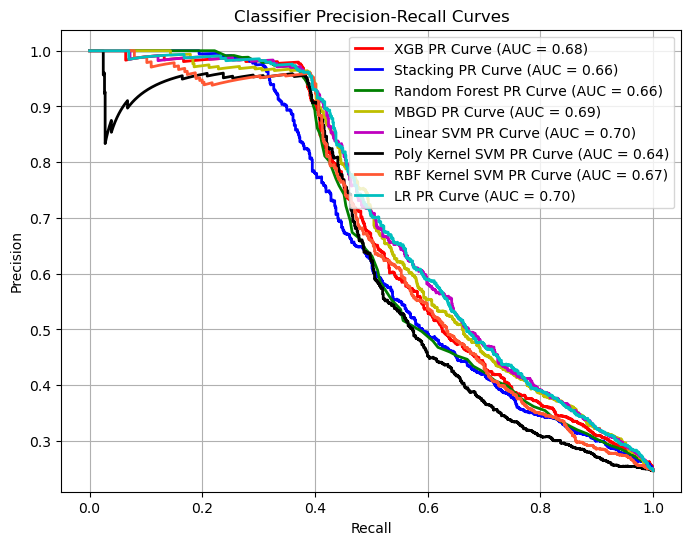

In [529]:
plt.figure(figsize=(8, 6))


plt.plot(xgb_recall, xgb_precision, color='r', lw=2, label=f'XGB PR Curve (AUC = {xgb_pr_auc:.2f})')
plt.plot(stack_recall, stack_precision, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_pr_auc:.2f})')
plt.plot(rf_recall, rf_precision, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_pr_auc:.2f})')
plt.plot(mbgd_recall, mbgd_precision, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_pr_auc:.2f})')
plt.plot(lsvm_recall, lsvm_precision, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_pr_auc:.2f})')
plt.plot(pksvm_recall, pksvm_precision, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_pr_auc:.2f})')
plt.plot(rbfksvm_recall, rbfksvm_precision, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_pr_auc:.2f})')
plt.plot(lg_recall, lg_precision, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Classifier Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

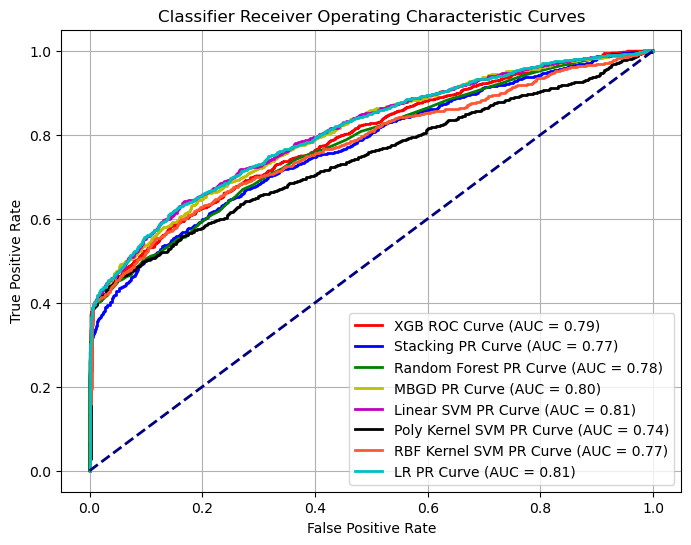

In [530]:
plt.figure(figsize=(8, 6))

plt.plot(xgb_fpr, xgb_tpr, color='r', lw=2, label=f'XGB ROC Curve (AUC = {xgb_roc_auc:.2f})')
plt.plot(stack_fpr, stack_tpr, color='b', lw=2, label=f'Stacking PR Curve (AUC = {stack_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='g', lw=2, label=f'Random Forest PR Curve (AUC = {rf_roc_auc:.2f})')
plt.plot(mbgd_fpr, mbgd_tpr, color='y', lw=2, label=f'MBGD PR Curve (AUC = {mbgd_roc_auc:.2f})')
plt.plot(lsvm_fpr, lsvm_tpr, color='m', lw=2, label=f'Linear SVM PR Curve (AUC = {lsvm_roc_auc:.2f})')
plt.plot(pksvm_fpr, pksvm_tpr, color='k', lw=2, label=f'Poly Kernel SVM PR Curve (AUC = {pksvm_roc_auc:.2f})')
plt.plot(rbfksvm_fpr, rbfksvm_tpr, color='#FF5733', lw=2, label=f'RBF Kernel SVM PR Curve (AUC = {rbfksvm_roc_auc:.2f})')
plt.plot(lg_fpr, lg_tpr, color='c', lw=2, label=f'LR PR Curve (AUC = {lg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classifier Receiver Operating Characteristic Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Curious about the new distributions

#### Visualization of Categorical Features' Distributions

In [533]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18370 entries, 40 to 3682
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id                               18370 non-null  int64  
 1   emp_length_num                   18370 non-null  int64  
 2   Debt-To-Income Ratio             18370 non-null  float64
 3   revol_util                       18370 non-null  float64
 4   od_ratio                         18370 non-null  float64
 5   annual_income_log                18370 non-null  float64
 6   grade_A                          18370 non-null  bool   
 7   grade_B                          18370 non-null  bool   
 8   grade_C                          18370 non-null  bool   
 9   grade_D                          18370 non-null  bool   
 10  grade_E                          18370 non-null  bool   
 11  grade_F                          18370 non-null  bool   
 12  grade_G                

In [534]:
original_cols = ['grade','home','purpose', 'term','last', 'total']
df_joined_copied = df_new.copy() #df_joined_copied is throw-away for graphing categorical features' distributions only

In [535]:
for col in original_cols:
    df_joined_copied[col] = pd.Series(dtype=str)

for encoded_col in df_new.columns:
    feature_name = encoded_col.split('_')[0]
    if feature_name not in original_cols:
        continue
    special_char_index = encoded_col.index('_')
    sliced_string = encoded_col[special_char_index+1:]
    indices = df_new[df_new[encoded_col]==1].index
    df_joined_copied.loc[indices, feature_name]=sliced_string

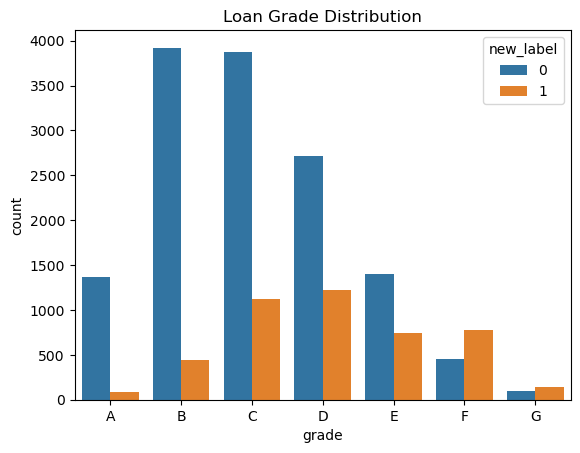

In [536]:
grade_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
sns.countplot(x=df_joined_copied.grade, hue=df_joined_copied.new_label, order=grade_order);
plt.title('Loan Grade Distribution');

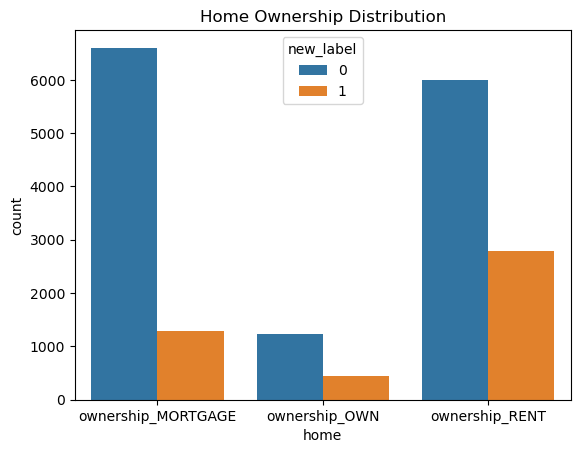

In [537]:
sns.countplot(x=df_joined_copied.home, hue=df_joined_copied.new_label);
plt.title('Home Ownership Distribution');

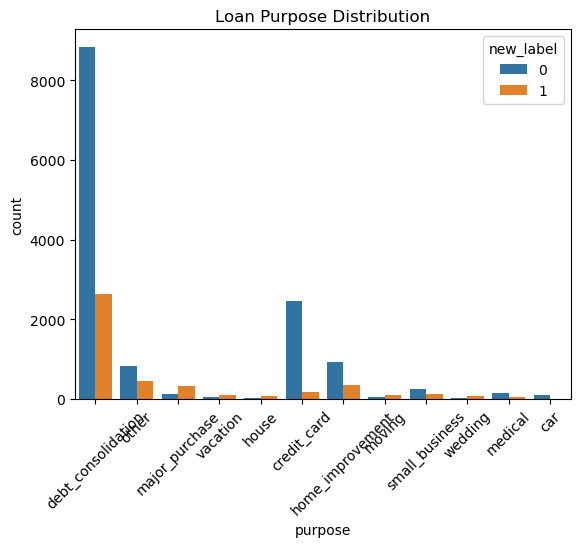

In [538]:
sns.countplot(x=df_joined_copied.purpose, hue=df_joined_copied.new_label);
plt.xticks(rotation=45)
plt.title('Loan Purpose Distribution');

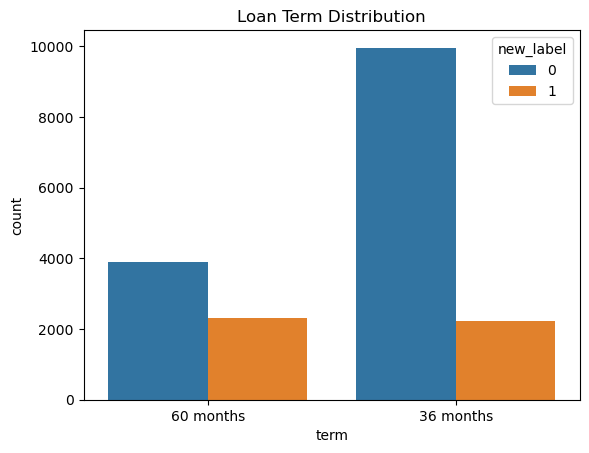

In [539]:
sns.countplot(x=df_joined_copied.term, hue=df_joined_copied.new_label);
plt.title('Loan Term Distribution');

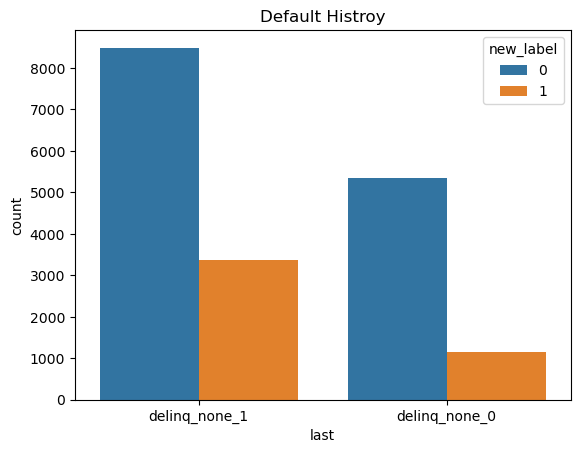

In [540]:
#Last _ delinq _ none - 1 when the debit has been in default at least once.
sns.countplot(x=df_joined_copied['last'], hue=df_joined_copied.new_label);
plt.title('Default Histroy');

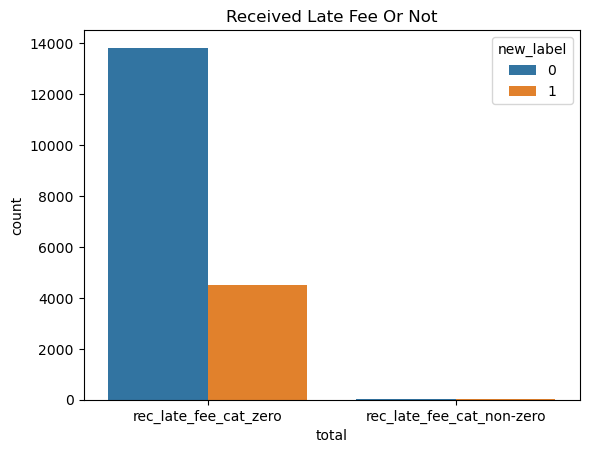

In [541]:
sns.countplot(x=df_joined_copied['total'], hue=df_joined_copied.new_label);
plt.title('Received Late Fee Or Not');

#### Visualization of Continuous Features' Distributions

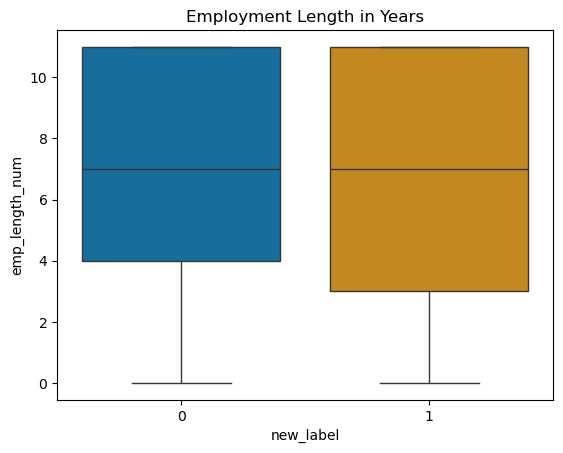

In [543]:
sns.boxplot(y='emp_length_num',
                x ='new_label',
                data=df_new,
           palette = 'colorblind');
plt.title('Employment Length in Years')
plt.show()

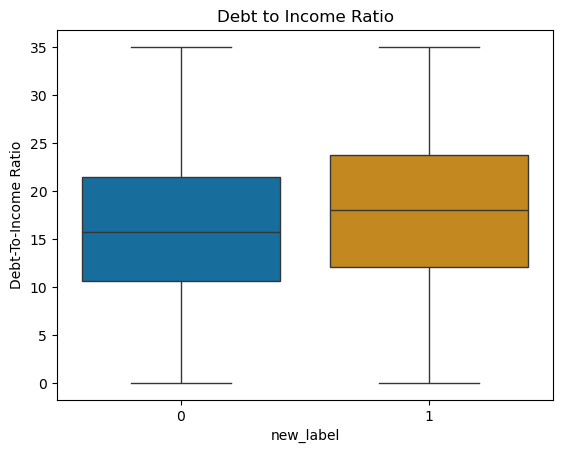

In [544]:
sns.boxplot(y='Debt-To-Income Ratio',
                x='new_label',
                data=df_new,
           palette = 'colorblind');
plt.title('Debt to Income Ratio')
plt.show()

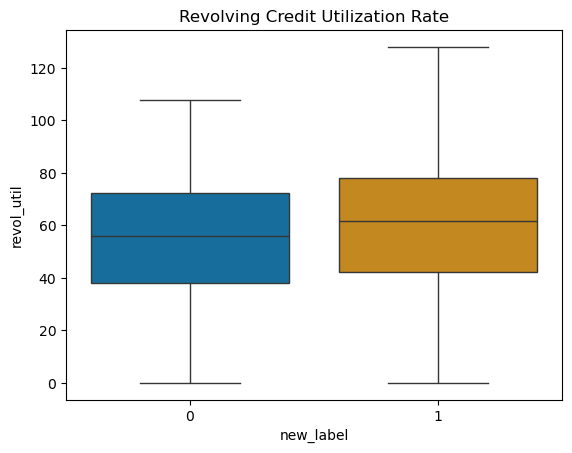

In [545]:
sns.boxplot(y='revol_util',
                x='new_label',
                data=df_new,
           palette = 'colorblind');
plt.title('Revolving Credit Utilization Rate')
plt.show()

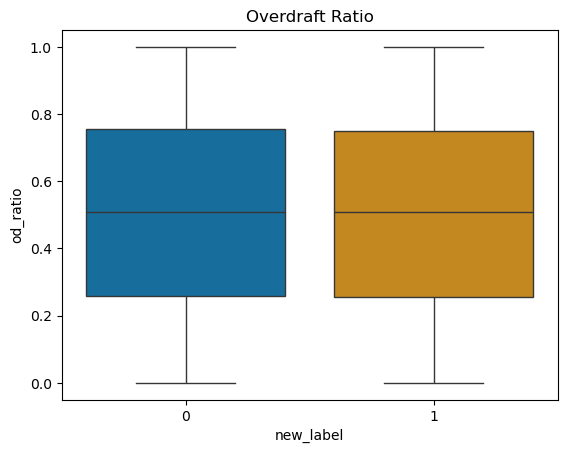

In [546]:
sns.boxplot(y='od_ratio',
                x='new_label',
                data=df_new,
           palette = 'colorblind');
plt.title('Overdraft Ratio')
plt.show()

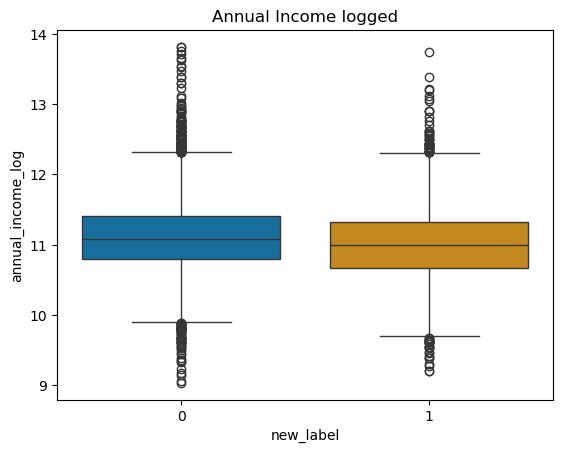

In [547]:
sns.boxplot(y='annual_income_log',
                x='new_label',
                data=df_new,
           palette = 'colorblind');
plt.title('Annual Income logged')
plt.show()